In [1]:
import mrcfile
import numpy as np
import matplotlib.pyplot as plt
import hyperspy.api as hs


In [2]:
fnDmDefect = 'K3-18210046PixelDefectMap.m1.kv300.dm4'
fnDmGain = 'K3-18210046_GainRef.x1.m1.kv300.dm4'

In [3]:
DmDefect = hs.load(fnDmDefect)
DmGain = hs.load(fnDmGain) 
#DmGain = nio.read(fnDmGain)
# DmGain.metadata # cool function to look at metdata of dm4 filesin hyperspy

In [4]:
def rebin(im, f, funcType='sum'):
    """ Rebin a 2D array. From stackoverflow:
    https://stackoverflow.com/questions/4624112/grouping-2d-numpy-array-in-average
    https://github.com/ercius/openNCEM/blob/f3b284069bedf94107ac31ef3c23bcda684e4b5d/ncempy/algo/__init__.py#L8

    Parameters
    ----------
    im : ndarray
        2D array to reduce
    f : int
        The factor to rebin by. Must be integer
    funcType : str
        The type of reduction. mean or sum are implemented.

    Returns
    -------
    : ndarray
        The 2D array with the new size.
    """

    nbig = im.shape
    nsmall = [ii // f for ii in im.shape]

    # Reshape the array so that the required neighborhood are in arrays along certain axes
    # Then average or sum those neighborhoods
    im_reshape = im.reshape([nsmall[0], nbig[0] // nsmall[0], nsmall[1], nbig[1] // nsmall[1]])
    # Reduce using different types of functions
    if funcType == 'mean':
        small = im_reshape.mean(3).mean(1)
    elif funcType == 'sum':
        small = im_reshape.sum(3).sum(1)
    # elif funcType == 'median':
    #    small = im_reshape.median(3).median(1)
    else:
        print('defaulting to sum')
        small = im_reshape.sum(3).sum(1)

    return small

In [5]:
DmGain.metadata 

├── Acquisition_instrument
│   └── TEM
│       ├── Camera
│       │   └── exposure = 20.01792050044801
│       ├── Stage
│       │   ├── tilt_alpha = -0.028854097267008744
│       │   ├── x = -0.586736
│       │   ├── y = -0.183067
│       │   └── z = -0.0019814100000000003
│       ├── acquisition_mode = TEM
│       ├── beam_current = 0.0
│       ├── beam_energy = 300.0
│       ├── magnification = 15000.0
│       └── microscope = FEI Tecnai Remote TCPIP
├── General
│   ├── FileIO
│   │   └── 0
│   │       ├── hyperspy_version = 2.0
│   │       ├── io_plugin = rsciio.digitalmicrograph
│   │       ├── operation = load
│   │       └── timestamp = 2024-01-26T18:30:12.168219+01:00
│   ├── date = 2024-01-17
│   ├── original_filename = K3-18210046_GainRef.x1.m1.kv300.dm4
│   ├── time = 10:35:13
│   └── title = Prepare Gain Reference
└── Signal
    ├── Noise_properties
    │   └── Variance_linear_model
    │       ├── gain_factor = 1.0
    │       └── gain_offset = 0.0
    ├── quantity = Intensity
    └── signal_type =

In [6]:
print(DmDefect.data.shape) # the shape of the data
print(DmGain.data.shape) # the shape of the data

(8184, 11520)
(8184, 11520)


In [7]:
DmDefectBin = rebin(DmDefect.data, 2, funcType='mean')
DmGainBin = rebin(DmGain.data, 2, funcType='mean')
print(DmDefectBin.shape)
print(DmGainBin.shape)

(4092, 5760)
(4092, 5760)


Text(0.5, 1.0, 'Binned')

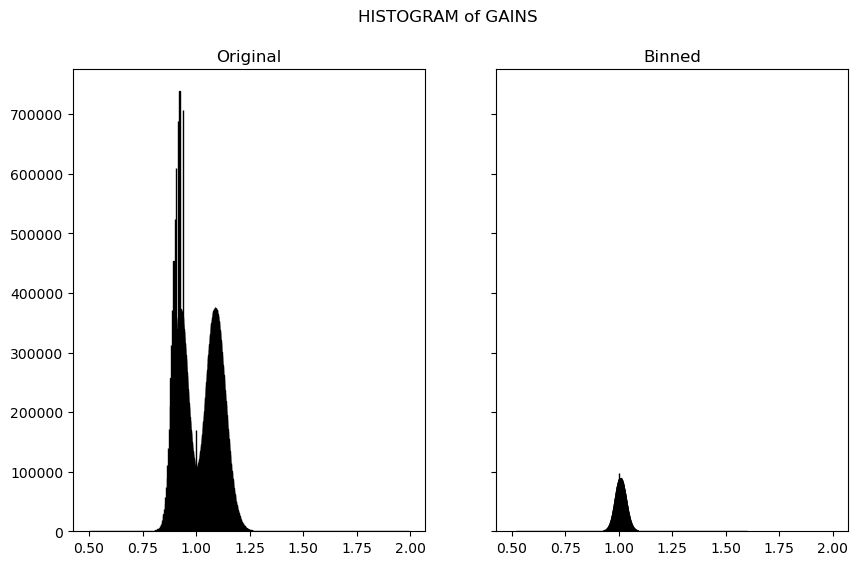

In [8]:
fig, axs = plt.subplots(1,2,sharex=True, sharey=True,figsize=(10,6))
fig.suptitle('HISTOGRAM of GAINS')
axs[0].hist(DmGain.data.ravel(), bins='auto', fc='k', ec='k')
axs[0].set_title('Original')
axs[1].hist(DmGainBin.ravel(), bins='auto', fc='k', ec='k')
axs[1].set_title('Binned')

In [9]:
# indices where value is greater than zero 
defectsbin = np.where(DmDefectBin > 0)

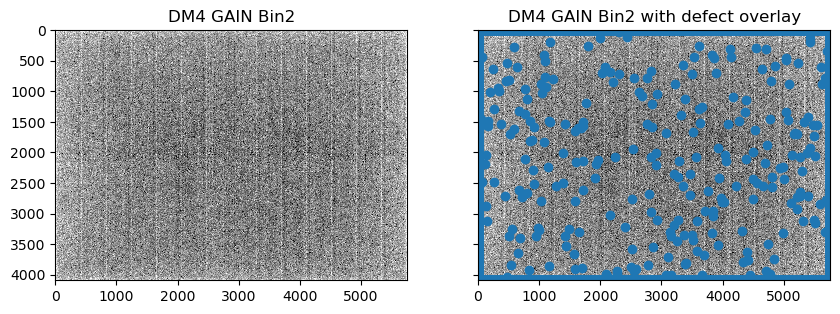

In [10]:
fig, axs = plt.subplots(1,2, sharex=True, sharey=True,figsize=(10,12))
axs[0].imshow(DmGainBin,interpolation='none', cmap='grey', clim=(0.92, 1.08) )
axs[0].set_title('DM4 GAIN Bin2')
axs[1].imshow(DmGainBin,interpolation='none', cmap='grey', clim=(0.92, 1.08) )
axs[1].scatter(defectsbin[1], defectsbin[0])
axs[1].set_title('DM4 GAIN Bin2 with defect overlay')
plt.savefig("DM4GAIN-DEFECT-Overlay.pdf", format="pdf", bbox_inches="tight")

In [11]:
# values in gain where defect 
values, counts = np.unique(DmGainBin[defectsbin[0], defectsbin[1]],return_counts=True)
print(values)
print(counts)

[0.6464555 0.6484538 0.648619  ... 1.3602467 1.4035338 1.407026 ]
[1 1 1 ... 1 1 1]


In [12]:
DmGainBin[defectsbin[0], defectsbin[1]] = 0
values, counts = np.unique(DmGainBin[defectsbin[0], defectsbin[1]],return_counts=True)
print(values)
print(counts)

[0.]
[19996]


Text(0.5, 1.0, 'DM4 GAIN Bin2 with defect overlay')

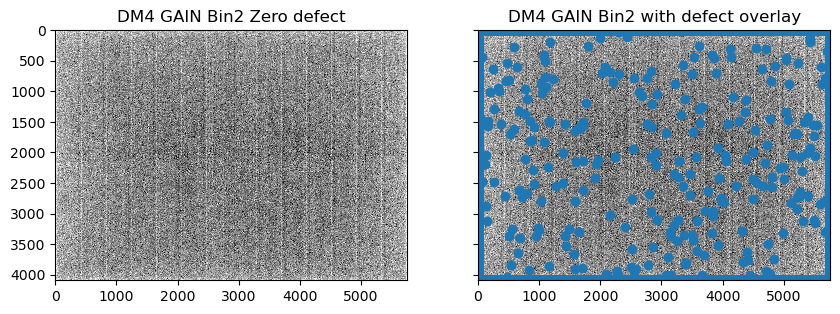

In [13]:
fig, axs = plt.subplots(1,2, sharex=True, sharey=True,figsize=(10,12))
axs[0].imshow(DmGainBin,interpolation='none', cmap='grey', clim=(0.92, 1.08) )
axs[0].set_title('DM4 GAIN Bin2 Zero defect')
axs[1].imshow(DmGainBin,interpolation='none', cmap='grey', clim=(0.92, 1.08) )
axs[1].scatter(defectsbin[1], defectsbin[0])
axs[1].set_title('DM4 GAIN Bin2 with defect overlay')

Text(0.5, 1.0, 'Binned/Defect')

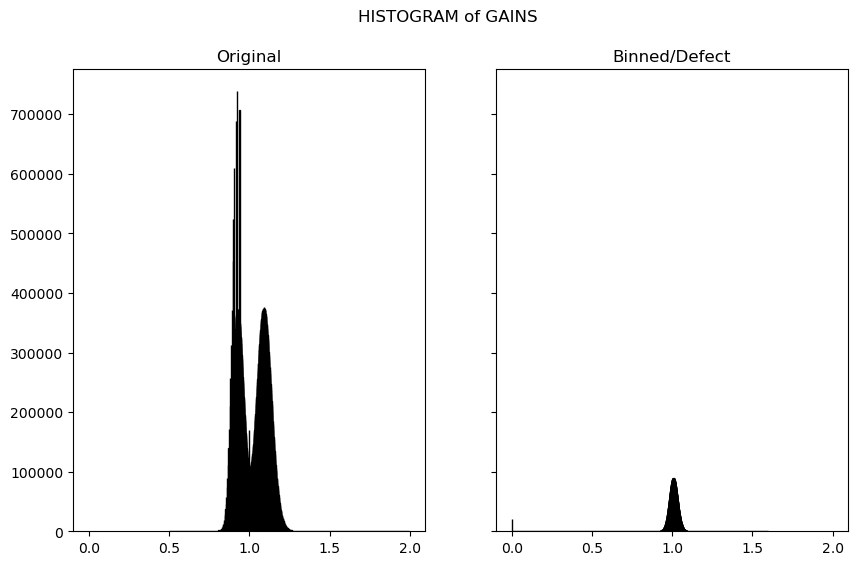

In [15]:
fig, axs = plt.subplots(1,2,sharex=True, sharey=True,figsize=(10,6))
fig.suptitle('HISTOGRAM of GAINS')
axs[0].hist(DmGain.data.ravel(), bins='auto', fc='k', ec='k')
axs[0].set_title('Original')
axs[1].hist(DmGainBin.ravel(), bins='auto', fc='k', ec='k')
axs[1].set_title('Binned/Defect')

In [16]:
foGain = 'gain_sean.mrc'

In [17]:
with mrcfile.new(foGain, overwrite=True) as mrc:
    mrc.set_data(DmGainBin)
    #mrc.set_image_stack()
    mrc.voxel_size = 1 # set with varialble todo
    mrc.update_header_from_data()